# 3D Multi-class Segmentation with UNETR  (Muscle, Fat (subcut and internal), psoas,cavity, BGD)

## Setup environment

In [1]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 0.10.dev2231
Numpy version: 1.23.1
Pytorch version: 1.12.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8236821c099e5997f7ad0410c5374e4472f4ed14
MONAI __file__: /home/adminbthomas/miniconda3/envs/PT02/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.9.1
gdown version: 4.5.1
TorchVision version: 0.13.0+cu102
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.3
einops version: 0.4.1
transformers version: 4.20.1
mlflow version: 1.27.0
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

In [10]:
# directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = "/home/adminbthomas/Downloads/data"# root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/home/adminbthomas/Downloads/data


UNETR(
  (vit): ViT(
    (patch_embedding): PatchEmbeddingBlock(
      (patch_embeddings): Sequential(
        (0): Rearrange('b c (h p1) (w p2) (d p3) -> b (h w d) (p1 p2 p3 c)', p1=16, p2=16, p3=16)
        (1): Linear(in_features=4096, out_features=768, bias=True)
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (blocks): ModuleList(
      (0): TransformerBlock(
        (mlp): MLPBlock(
          (linear1): Linear(in_features=768, out_features=3072, bias=True)
          (linear2): Linear(in_features=3072, out_features=768, bias=True)
          (fn): GELU(approximate=none)
          (drop1): Dropout(p=0.0, inplace=False)
          (drop2): Dropout(p=0.0, inplace=False)
        )
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): SABlock(
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (input_rearrange): Rearrange('b h (qkv l 

## Setup transforms for training and validation

In [4]:
import datetime
import time

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
#         AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 4.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=False,   # change-intermedouts 
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 16),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
#         SaveImaged(keys="image", meta_keys="image_meta_dict", output_dir="./outMR02_Jul23_Interinputs", output_postfix=datetime.datetime.now().strftime('%f'), resample=False, separate_folder=False),
#         SaveImaged(keys="label", meta_keys="label_meta_dict", output_dir="./outMR02_Jul23_Interinputs", output_postfix=datetime.datetime.now().strftime('%f'), resample=False, separate_folder=False),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
#         AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 4.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=250, b_min=0.0, b_max=1.0, clip=False
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

### DATA

In [5]:
data_dir = os.path.join(root_dir,"013123_MR/")

In [6]:
# data_dir = os.path.join(root_dir,"013123_MR/")
split_JSON = "dataset_MR04.json"
datasets = data_dir + split_JSON
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True
)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

Loading dataset:   0%|                                                                                                                                              | 0/12 [00:00<?, ?it/s]Modifying image pixdim from [1.4648438 1.4648438 4.        0.       ] to [  1.46484375   1.46484375   4.         268.45717811]
Modifying image pixdim from [1.4648438 1.4648438 8.        0.       ] to [  1.46484375   1.46484375   8.         281.03604124]
Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s]


In [7]:
data_dir = os.path.join(root_dir,"013123_MR/")
print(data_dir)
# help(val_loader)
# len(val_loader)

/home/adminbthomas/Downloads/data/013123_MR/


## Check data shape and visualize

image shape: torch.Size([1, 250, 171, 25]), label shape: torch.Size([1, 250, 171, 25])


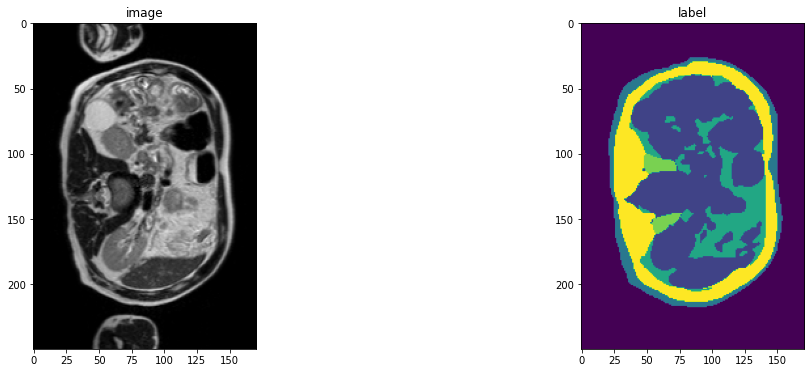

In [8]:
slice_map = {
    "A029_v4_T2W.nii.gz": 10,
    "A029_v4_T2W.nii.gz": 8,
    "A029_v4_T2W.nii.gz": 6
}
case_num = 3
img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

### Create Model, Loss, Optimizer


In [9]:
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda:0")

model = UNETR(
    in_channels=1,
    out_channels=6,
    img_size=(96, 96, 16),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

### Execute a typical PyTorch training process

In [10]:
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].to(device), batch["label"].to(device))
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 16), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].to(device), batch["label"].to(device))
#         print(x.shape)
#         print(y.shape)
#         plt.figure("image", (18, 6))
#         plt.subplot(1, 2, 1)
#         plt.title("image")
#         plt.imshow(x[3,0,:,:,4].detach().cpu(), cmap="gray")
#         plt.subplot(1, 2, 2)
#         plt.title("label")
#         plt.imshow(y[3,0,:,:,4].detach().cpu())
#         plt.show()
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(data_dir, "TestMR05_multiclassUNetR_Sep23.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
        
    return global_step, dice_val_best, global_step_best


max_iterations = 70000
eval_num = 250
post_label = AsDiscrete(to_onehot=6)
post_pred = AsDiscrete(argmax=True, to_onehot=6)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
#     print('I am waiting....')
#     time.sleep(1)
model.load_state_dict(torch.load(os.path.join(data_dir, "TestMR05_multiclassUNetR_Sep23.pth")))

Training (251 / 70000 Steps) (loss=2.15354): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  1.45it/s]

Model Was Saved ! Current Best Avg. Dice: 0.617066102368491 Current Avg. Dice: 0.617066102368491


Training (501 / 70000 Steps) (loss=1.32011):  83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                  | 10/12 [00:04<00:01,  1.40it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6670307006154742 Current Avg. Dice: 0.6670307006154742


Training (751 / 70000 Steps) (loss=1.52808):  67%|███████████████████████████████████████████████████████████████████████████▎                                     | 8/12 [00:04<00:03,  1.33it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6881155116217477 Current Avg. Dice: 0.6881155116217477


Training (1001 / 70000 Steps) (loss=1.30446):  50%|████████████████████████████████████████████████████████                                                        | 6/12 [00:04<00:04,  1.22it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6944950563567025 Current Avg. Dice: 0.6944950563567025


Training (1251 / 70000 Steps) (loss=1.08327):  33%|█████████████████████████████████████▎                                                                          | 4/12 [00:03<00:07,  1.04it/s]

Model Was Saved ! Current Best Avg. Dice: 0.7166187507765633 Current Avg. Dice: 0.7166187507765633


Training (1501 / 70000 Steps) (loss=0.99895):  17%|██████████████████▋                                                                                             | 2/12 [00:03<00:14,  1.49s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7240514414651054 Current Avg. Dice: 0.7240514414651054


Training (1751 / 70000 Steps) (loss=1.21573): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  1.40it/s]

Model Was Saved ! Current Best Avg. Dice: 0.7312323025294712 Current Avg. Dice: 0.7312323025294712


Training (2001 / 70000 Steps) (loss=0.92793):  83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 10/12 [00:04<00:01,  1.61it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.7312323025294712 Current Avg. Dice: 0.7274889179638454


Training (2251 / 70000 Steps) (loss=0.77640):  67%|██████████████████████████████████████████████████████████████████████████▋                                     | 8/12 [00:04<00:02,  1.34it/s]

Model Was Saved ! Current Best Avg. Dice: 0.73198173727308 Current Avg. Dice: 0.73198173727308


Training (2501 / 70000 Steps) (loss=0.70344):  50%|████████████████████████████████████████████████████████                                                        | 6/12 [00:04<00:04,  1.26it/s]

Model Was Saved ! Current Best Avg. Dice: 0.7371653148106166 Current Avg. Dice: 0.7371653148106166


Training (2751 / 70000 Steps) (loss=0.65482):  33%|█████████████████████████████████████▎                                                                          | 4/12 [00:03<00:07,  1.04it/s]

Model Was Saved ! Current Best Avg. Dice: 0.7489921876362392 Current Avg. Dice: 0.7489921876362392


Training (3001 / 70000 Steps) (loss=0.81273):  17%|██████████████████▋                                                                                             | 2/12 [00:02<00:12,  1.23s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7489921876362392 Current Avg. Dice: 0.7413788097245353


Training (3251 / 70000 Steps) (loss=1.14185): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  1.38it/s]

Model Was Saved ! Current Best Avg. Dice: 0.752954261643546 Current Avg. Dice: 0.752954261643546


Training (3501 / 70000 Steps) (loss=0.62643):  83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 10/12 [00:04<00:01,  1.60it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.752954261643546 Current Avg. Dice: 0.750860938004085


Training (3751 / 70000 Steps) (loss=0.75208):  67%|██████████████████████████████████████████████████████████████████████████▋                                     | 8/12 [00:04<00:02,  1.52it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.752954261643546 Current Avg. Dice: 0.7432358860969543


Training (4001 / 70000 Steps) (loss=0.78351):  50%|████████████████████████████████████████████████████████                                                        | 6/12 [00:03<00:04,  1.45it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.752954261643546 Current Avg. Dice: 0.748923693384443


Training (4251 / 70000 Steps) (loss=0.64903):  33%|█████████████████████████████████████▎                                                                          | 4/12 [00:03<00:07,  1.05it/s]

Model Was Saved ! Current Best Avg. Dice: 0.7569597789219448 Current Avg. Dice: 0.7569597789219448


Training (4501 / 70000 Steps) (loss=0.60142):  17%|██████████████████▋                                                                                             | 2/12 [00:03<00:12,  1.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7569597789219448 Current Avg. Dice: 0.7538883345467704


Training (4751 / 70000 Steps) (loss=0.59501): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  1.41it/s]

Model Was Saved ! Current Best Avg. Dice: 0.7574725065912519 Current Avg. Dice: 0.7574725065912519


Training (5001 / 70000 Steps) (loss=0.53546):  83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 10/12 [00:04<00:01,  1.38it/s]

Model Was Saved ! Current Best Avg. Dice: 0.7619291118213108 Current Avg. Dice: 0.7619291118213108


Training (5251 / 70000 Steps) (loss=0.87048):  67%|██████████████████████████████████████████████████████████████████████████▋                                     | 8/12 [00:03<00:02,  1.57it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.7619291118213108 Current Avg. Dice: 0.7615600483758109


Training (6001 / 70000 Steps) (loss=0.76465):  17%|██████████████████▋                                                                                             | 2/12 [00:03<00:14,  1.49s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7624913283756801 Current Avg. Dice: 0.7624913283756801


Training (6251 / 70000 Steps) (loss=1.05127): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  1.61it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.7624913283756801 Current Avg. Dice: 0.7551702601569039


Training (6501 / 70000 Steps) (loss=0.91535):  83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 10/12 [00:04<00:01,  1.63it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.7624913283756801 Current Avg. Dice: 0.7613030757222857


Training (6751 / 70000 Steps) (loss=0.66458):  67%|██████████████████████████████████████████████████████████████████████████▋                                     | 8/12 [00:03<00:02,  1.57it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.7624913283756801 Current Avg. Dice: 0.7615793262209211


Training (7001 / 70000 Steps) (loss=0.99067):  50%|████████████████████████████████████████████████████████                                                        | 6/12 [00:03<00:04,  1.45it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.7624913283756801 Current Avg. Dice: 0.7548419066837856


Training (7019 / 70000 Steps) (loss=0.60399): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  6.59it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (13751 / 70000 Steps) (loss=0.46065): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  1.64it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9067021608352661 Current Avg. Dice: 0.9052460619381496


Training (14001 / 70000 Steps) (loss=0.36539):  83%|███████████████████████████████████████████████████████████████████████████████████████████▋                  | 10/12 [00:04<00:01,  1.60it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9067021608352661 Current Avg. Dice: 0.8990893619401115


Training (14251 / 70000 Steps) (loss=0.48992):  67%|██████████████████████████████████████████████████████████████████████████                                     | 8/12 [00:04<00:02,  1.34it/s]

Model Was Saved ! Current Best Avg. Dice: 0.9080045648983547 Current Avg. Dice: 0.9080045648983547


Training (14501 / 70000 Steps) (loss=0.39584):  50%|███████████████████████████████████████████████████████▌                                                       | 6/12 [00:03<00:04,  1.47it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9080045648983547 Current Avg. Dice: 0.9034412418093


Training (14751 / 70000 Steps) (loss=0.49218):  33%|█████████████████████████████████████                                                                          | 4/12 [00:03<00:06,  1.23it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9080045648983547 Current Avg. Dice: 0.9071102908679417


Training (14771 / 70000 Steps) (loss=0.38404): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.90it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (21251 / 70000 Steps) (loss=0.46768): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  1.39it/s]

Model Was Saved ! Current Best Avg. Dice: 0.9126146180289132 Current Avg. Dice: 0.9126146180289132


Training (21501 / 70000 Steps) (loss=0.49342):  83%|███████████████████████████████████████████████████████████████████████████████████████████▋                  | 10/12 [00:04<00:01,  1.62it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126146180289132 Current Avg. Dice: 0.9039887871061053


Training (21751 / 70000 Steps) (loss=0.40577):  67%|██████████████████████████████████████████████████████████████████████████                                     | 8/12 [00:03<00:02,  1.57it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126146180289132 Current Avg. Dice: 0.911844687802451


Training (22001 / 70000 Steps) (loss=0.39982):  50%|███████████████████████████████████████████████████████▌                                                       | 6/12 [00:03<00:04,  1.44it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126146180289132 Current Avg. Dice: 0.9099628925323486


Training (22251 / 70000 Steps) (loss=0.36542):  33%|█████████████████████████████████████                                                                          | 4/12 [00:03<00:06,  1.19it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9126146180289132 Current Avg. Dice: 0.9001155410494123


Training (22424 / 70000 Steps) (loss=0.31445):  75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 9/12 [00:01<00:00,  6.33it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (29001 / 70000 Steps) (loss=0.49437):  83%|███████████████████████████████████████████████████████████████████████████████████████████▋                  | 10/12 [00:04<00:01,  1.59it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9161775878497532 Current Avg. Dice: 0.9127701350620815


Training (29251 / 70000 Steps) (loss=0.30692):  67%|██████████████████████████████████████████████████████████████████████████                                     | 8/12 [00:04<00:02,  1.54it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9161775878497532 Current Avg. Dice: 0.9088171805654254


Training (29501 / 70000 Steps) (loss=0.35697):  50%|███████████████████████████████████████████████████████▌                                                       | 6/12 [00:03<00:04,  1.45it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9161775878497532 Current Avg. Dice: 0.9136280843189785


Training (29751 / 70000 Steps) (loss=0.48315):  33%|█████████████████████████████████████                                                                          | 4/12 [00:03<00:06,  1.22it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9161775878497532 Current Avg. Dice: 0.9081947803497314


Training (30001 / 70000 Steps) (loss=0.41350):  17%|██████████████████▌                                                                                            | 2/12 [00:03<00:13,  1.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9161775878497532 Current Avg. Dice: 0.9062835829598563


Training (30143 / 70000 Steps) (loss=0.51231): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.72it/s]
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (36501 / 70000 Steps) (loss=0.44080):  83%|███████████████████████████████████████████████████████████████████████████████████████████▋                  | 10/12 [00:04<00:01,  1.61it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9161775878497532 Current Avg. Dice: 0.9117626122065953


Training (36751 / 70000 Steps) (loss=0.47482):  67%|██████████████████████████████████████████████████████████████████████████                                     | 8/12 [00:03<00:02,  1.55it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9161775878497532 Current Avg. Dice: 0.904518016747066


Training (37001 / 70000 Steps) (loss=0.34537):  50%|███████████████████████████████████████████████████████▌                                                       | 6/12 [00:03<00:04,  1.44it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9161775878497532 Current Avg. Dice: 0.9144335559436253


Training (37251 / 70000 Steps) (loss=0.32472):  33%|█████████████████████████████████████                                                                          | 4/12 [00:03<00:06,  1.22it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9161775878497532 Current Avg. Dice: 0.908840503011431


Training (37501 / 70000 Steps) (loss=0.39606):  17%|██████████████████▌                                                                                            | 2/12 [00:03<00:14,  1.48s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9163747089249747 Current Avg. Dice: 0.9163747089249747


Training (37663 / 70000 Steps) (loss=0.36511):  67%|██████████████████████████████████████████████████████████████████████████                                     | 8/12 [00:01<00:00,  6.00it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (44001 / 70000 Steps) (loss=0.28122):  83%|███████████████████████████████████████████████████████████████████████████████████████████▋                  | 10/12 [00:04<00:01,  1.57it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.913867712020874


Training (44251 / 70000 Steps) (loss=0.24796):  67%|██████████████████████████████████████████████████████████████████████████                                     | 8/12 [00:04<00:02,  1.56it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9126096538134983


Training (44501 / 70000 Steps) (loss=0.24392):  50%|███████████████████████████████████████████████████████▌                                                       | 6/12 [00:03<00:04,  1.41it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.912322998046875


Training (44751 / 70000 Steps) (loss=0.37105):  33%|█████████████████████████████████████                                                                          | 4/12 [00:03<00:06,  1.20it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9163555588041034


Validate (45000 / 10 Steps) (dice=0.92350):   0%|                                                                                                                           | 0/7 [00:00<?, ?it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (46001 / 70000 Steps) (loss=0.34287):  50%|███████████████████████████████████████████████████████▌                                                       | 6/12 [00:03<00:04,  1.46it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9136414698192051


Training (46251 / 70000 Steps) (loss=0.37930):  33%|█████████████████████████████████████                                                                          | 4/12 [00:03<00:06,  1.21it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9086150356701442


Training (46501 / 70000 Steps) (loss=0.39141):  17%|██████████████████▌                                                                                            | 2/12 [00:03<00:12,  1.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9158280491828918


Training (46751 / 70000 Steps) (loss=0.24614): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  1.65it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9115417855126517


Training (47001 / 70000 Steps) (loss=0.37819):  83%|███████████████████████████████████████████████████████████████████████████████████████████▋                  | 10/12 [00:04<00:01,  1.61it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9191957116127014


Training (47251 / 70000 Steps) (loss=0.30675):  67%|██████████████████████████████████████████████████████████████████████████                                     | 8/12 [00:03<00:02,  1.55it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9177381992340088


Training (47501 / 70000 Steps) (loss=0.35725):  50%|███████████████████████████████████████████████████████▌                                                       | 6/12 [00:03<00:04,  1.45it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9094842331750053


Training (47751 / 70000 Steps) (loss=0.22798):  33%|█████████████████████████████████████                                                                          | 4/12 [00:03<00:06,  1.23it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9153487001146589


Training (48001 / 70000 Steps) (loss=0.35802):  17%|██████████████████▌                                                                                            | 2/12 [00:03<00:13,  1.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9139747534479413


Training (48251 / 70000 Steps) (loss=0.25976): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  1.62it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9117005978311811


Training (48501 / 70000 Steps) (loss=0.32959):  83%|███████████████████████████████████████████████████████████████████████████████████████████▋                  | 10/12 [00:04<00:01,  1.59it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9111183030264718


Training (48751 / 70000 Steps) (loss=0.30978):  67%|██████████████████████████████████████████████████████████████████████████                                     | 8/12 [00:03<00:02,  1.57it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9144829256193978


Training (49001 / 70000 Steps) (loss=0.37328):  50%|███████████████████████████████████████████████████████▌                                                       | 6/12 [00:03<00:04,  1.39it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9159455725124904


Training (49251 / 70000 Steps) (loss=0.29512):  33%|█████████████████████████████████████                                                                          | 4/12 [00:03<00:06,  1.17it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9146380169051034


Training (49501 / 70000 Steps) (loss=0.32889):  17%|██████████████████▌                                                                                            | 2/12 [00:03<00:13,  1.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.912341126373836


Training (49751 / 70000 Steps) (loss=0.35275): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  1.61it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9171169740813119


Training (50001 / 70000 Steps) (loss=0.39507):  83%|███████████████████████████████████████████████████████████████████████████████████████████▋                  | 10/12 [00:04<00:01,  1.60it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9167746560914176


Training (50251 / 70000 Steps) (loss=0.35409):  67%|██████████████████████████████████████████████████████████████████████████                                     | 8/12 [00:04<00:02,  1.54it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9134085263524737


Training (50501 / 70000 Steps) (loss=0.31785):  50%|███████████████████████████████████████████████████████▌                                                       | 6/12 [00:03<00:04,  1.44it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9160223177501133


Training (50751 / 70000 Steps) (loss=0.20150):  33%|█████████████████████████████████████                                                                          | 4/12 [00:03<00:06,  1.21it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9131514089448112


Training (51001 / 70000 Steps) (loss=0.40555):  17%|██████████████████▌                                                                                            | 2/12 [00:03<00:12,  1.28s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9149784701211112


Training (51251 / 70000 Steps) (loss=0.28840): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  1.67it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9173702938216073


Training (51501 / 70000 Steps) (loss=0.43009):  83%|███████████████████████████████████████████████████████████████████████████████████████████▋                  | 10/12 [00:04<00:01,  1.62it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.91032475233078


Training (51751 / 70000 Steps) (loss=0.25003):  67%|██████████████████████████████████████████████████████████████████████████                                     | 8/12 [00:03<00:02,  1.54it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9165356499808175


Training (52001 / 70000 Steps) (loss=0.41627):  50%|███████████████████████████████████████████████████████▌                                                       | 6/12 [00:03<00:04,  1.43it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9191494839532035


Training (52251 / 70000 Steps) (loss=0.33500):  33%|█████████████████████████████████████                                                                          | 4/12 [00:03<00:06,  1.17it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9120412724358695


Training (52501 / 70000 Steps) (loss=0.31106):  17%|██████████████████▌                                                                                            | 2/12 [00:03<00:12,  1.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9156111819403512


Training (52751 / 70000 Steps) (loss=0.33025): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  1.61it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9129542027200971


Training (53001 / 70000 Steps) (loss=0.25954):  83%|███████████████████████████████████████████████████████████████████████████████████████████▋                  | 10/12 [00:04<00:01,  1.62it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9142061216490609


Training (53251 / 70000 Steps) (loss=0.46976):  67%|██████████████████████████████████████████████████████████████████████████                                     | 8/12 [00:03<00:02,  1.55it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9133910451616559


Training (53501 / 70000 Steps) (loss=0.27378):  50%|███████████████████████████████████████████████████████▌                                                       | 6/12 [00:03<00:04,  1.43it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.917292731148856


Training (53751 / 70000 Steps) (loss=0.31618):  33%|█████████████████████████████████████                                                                          | 4/12 [00:03<00:06,  1.20it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9158723865236554


Training (54001 / 70000 Steps) (loss=0.46227):  17%|██████████████████▌                                                                                            | 2/12 [00:03<00:12,  1.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9144683139664787


Training (54251 / 70000 Steps) (loss=0.40869): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  1.63it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9141680598258972


Training (54501 / 70000 Steps) (loss=0.25497):  83%|███████████████████████████████████████████████████████████████████████████████████████████▋                  | 10/12 [00:04<00:01,  1.60it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200058494295392 Current Avg. Dice: 0.9122552531106132


Training (54751 / 70000 Steps) (loss=0.25089):  67%|██████████████████████████████████████████████████████████████████████████                                     | 8/12 [00:04<00:03,  1.28it/s]

Model Was Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9200466360364642


Training (55001 / 70000 Steps) (loss=0.38141):  50%|███████████████████████████████████████████████████████▌                                                       | 6/12 [00:03<00:04,  1.44it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9157161116600037


Training (55251 / 70000 Steps) (loss=0.36353):  33%|█████████████████████████████████████                                                                          | 4/12 [00:03<00:06,  1.24it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.913443888936724


Training (55501 / 70000 Steps) (loss=0.27295):  17%|██████████████████▌                                                                                            | 2/12 [00:03<00:13,  1.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9105390225137983


Training (55751 / 70000 Steps) (loss=0.48575): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  1.63it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.917574908052172


Training (56001 / 70000 Steps) (loss=0.36901):  83%|███████████████████████████████████████████████████████████████████████████████████████████▋                  | 10/12 [00:04<00:01,  1.61it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9117922357150486


Training (56251 / 70000 Steps) (loss=0.19746):  67%|██████████████████████████████████████████████████████████████████████████                                     | 8/12 [00:04<00:02,  1.53it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.916226829801287


Training (56501 / 70000 Steps) (loss=0.29853):  50%|███████████████████████████████████████████████████████▌                                                       | 6/12 [00:03<00:04,  1.42it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9190527200698853


Training (56751 / 70000 Steps) (loss=0.26152):  33%|█████████████████████████████████████                                                                          | 4/12 [00:03<00:06,  1.21it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9107679043497358


Training (57001 / 70000 Steps) (loss=0.17644):  17%|██████████████████▌                                                                                            | 2/12 [00:03<00:14,  1.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9159347925867353


Training (57251 / 70000 Steps) (loss=0.21629): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  1.65it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9132186344691685


Training (57501 / 70000 Steps) (loss=0.43488):  83%|███████████████████████████████████████████████████████████████████████████████████████████▋                  | 10/12 [00:04<00:01,  1.62it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.915700478213174


Training (57751 / 70000 Steps) (loss=0.28684):  67%|██████████████████████████████████████████████████████████████████████████                                     | 8/12 [00:03<00:02,  1.53it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9144535490444728


Training (58001 / 70000 Steps) (loss=0.26752):  50%|███████████████████████████████████████████████████████▌                                                       | 6/12 [00:03<00:04,  1.43it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9174732054982867


Training (58251 / 70000 Steps) (loss=0.36666):  33%|█████████████████████████████████████                                                                          | 4/12 [00:03<00:06,  1.20it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9164404783930097


Training (58501 / 70000 Steps) (loss=0.38269):  17%|██████████████████▌                                                                                            | 2/12 [00:03<00:12,  1.29s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9171114308493478


Training (58751 / 70000 Steps) (loss=0.42061): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  1.64it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.91353839635849


Training (59001 / 70000 Steps) (loss=0.27867):  83%|███████████████████████████████████████████████████████████████████████████████████████████▋                  | 10/12 [00:04<00:01,  1.60it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.919775630746569


Training (59251 / 70000 Steps) (loss=0.30583):  67%|██████████████████████████████████████████████████████████████████████████                                     | 8/12 [00:03<00:02,  1.55it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.916854475225721


Training (59501 / 70000 Steps) (loss=0.31444):  50%|███████████████████████████████████████████████████████▌                                                       | 6/12 [00:03<00:04,  1.39it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.915535569190979


Training (59751 / 70000 Steps) (loss=0.33763):  33%|█████████████████████████████████████                                                                          | 4/12 [00:03<00:06,  1.20it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9148154429027012


Training (60001 / 70000 Steps) (loss=0.43447):  17%|██████████████████▌                                                                                            | 2/12 [00:03<00:12,  1.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9169319953237262


Training (60251 / 70000 Steps) (loss=0.25309): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  1.64it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9153945616313389


Training (60501 / 70000 Steps) (loss=0.35105):  83%|███████████████████████████████████████████████████████████████████████████████████████████▋                  | 10/12 [00:04<00:01,  1.63it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.915160766669682


Training (60751 / 70000 Steps) (loss=0.23944):  67%|██████████████████████████████████████████████████████████████████████████                                     | 8/12 [00:04<00:02,  1.52it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9195659671510968


Training (61001 / 70000 Steps) (loss=0.27405):  50%|███████████████████████████████████████████████████████▌                                                       | 6/12 [00:03<00:04,  1.46it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9179525886263166


Training (61251 / 70000 Steps) (loss=0.25387):  33%|█████████████████████████████████████                                                                          | 4/12 [00:03<00:06,  1.19it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9172890952655247


Training (61501 / 70000 Steps) (loss=0.41668):  17%|██████████████████▌                                                                                            | 2/12 [00:03<00:13,  1.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9188481313841683


Training (61751 / 70000 Steps) (loss=0.28776): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  1.65it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9182833433151245


Training (62001 / 70000 Steps) (loss=0.39952):  83%|███████████████████████████████████████████████████████████████████████████████████████████▋                  | 10/12 [00:04<00:01,  1.61it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9149958065577916


Training (62251 / 70000 Steps) (loss=0.23386):  67%|██████████████████████████████████████████████████████████████████████████                                     | 8/12 [00:04<00:02,  1.53it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9160850048065186


Training (62501 / 70000 Steps) (loss=0.25259):  50%|███████████████████████████████████████████████████████▌                                                       | 6/12 [00:03<00:04,  1.45it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9114820275987897


Training (62751 / 70000 Steps) (loss=0.40437):  33%|█████████████████████████████████████                                                                          | 4/12 [00:03<00:07,  1.14it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9144994020462036


Training (63001 / 70000 Steps) (loss=0.40683):  17%|██████████████████▌                                                                                            | 2/12 [00:03<00:13,  1.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9025083099092756


Training (63251 / 70000 Steps) (loss=0.27433): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  1.61it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9091541171073914


Training (63501 / 70000 Steps) (loss=0.30564):  83%|███████████████████████████████████████████████████████████████████████████████████████████▋                  | 10/12 [00:04<00:01,  1.56it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9162138615335736


Training (63751 / 70000 Steps) (loss=0.26150):  67%|██████████████████████████████████████████████████████████████████████████                                     | 8/12 [00:04<00:02,  1.53it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9131279502596173


Training (64001 / 70000 Steps) (loss=0.36588):  50%|███████████████████████████████████████████████████████▌                                                       | 6/12 [00:03<00:04,  1.45it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9165064011301313


Training (64251 / 70000 Steps) (loss=0.38504):  33%|█████████████████████████████████████                                                                          | 4/12 [00:03<00:06,  1.19it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9189258643559047


Training (64501 / 70000 Steps) (loss=0.27807):  17%|██████████████████▌                                                                                            | 2/12 [00:03<00:12,  1.30s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9168756604194641


Training (64751 / 70000 Steps) (loss=0.25415): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  1.62it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9147346445492336


Training (65001 / 70000 Steps) (loss=0.31521):  83%|███████████████████████████████████████████████████████████████████████████████████████████▋                  | 10/12 [00:04<00:01,  1.64it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9171495607921055


Training (65251 / 70000 Steps) (loss=0.39113):  67%|██████████████████████████████████████████████████████████████████████████                                     | 8/12 [00:04<00:02,  1.55it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9156817197799683


Training (65501 / 70000 Steps) (loss=0.31342):  50%|███████████████████████████████████████████████████████▌                                                       | 6/12 [00:03<00:04,  1.42it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9200466360364642 Current Avg. Dice: 0.9175783395767212


Training (65751 / 70000 Steps) (loss=0.30714):  33%|█████████████████████████████████████                                                                          | 4/12 [00:03<00:07,  1.03it/s]

Model Was Saved ! Current Best Avg. Dice: 0.9204300216266087 Current Avg. Dice: 0.9204300216266087


Training (66001 / 70000 Steps) (loss=0.36874):  17%|██████████████████▌                                                                                            | 2/12 [00:03<00:13,  1.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9204300216266087 Current Avg. Dice: 0.9093159522329058


Training (66251 / 70000 Steps) (loss=0.36319): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  1.47it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9204300216266087 Current Avg. Dice: 0.9163105572972979


Training (66501 / 70000 Steps) (loss=0.32534):  83%|███████████████████████████████████████████████████████████████████████████████████████████▋                  | 10/12 [00:04<00:01,  1.55it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9204300216266087 Current Avg. Dice: 0.9184207405362811


Training (66751 / 70000 Steps) (loss=0.24231):  67%|██████████████████████████████████████████████████████████████████████████                                     | 8/12 [00:04<00:02,  1.54it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9204300216266087 Current Avg. Dice: 0.9132529837744576


Training (67001 / 70000 Steps) (loss=0.37759):  50%|███████████████████████████████████████████████████████▌                                                       | 6/12 [00:03<00:04,  1.43it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9204300216266087 Current Avg. Dice: 0.9142129336084638


Training (67251 / 70000 Steps) (loss=0.35196):  33%|█████████████████████████████████████                                                                          | 4/12 [00:03<00:06,  1.21it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9204300216266087 Current Avg. Dice: 0.9057107738086155


Training (67501 / 70000 Steps) (loss=0.28696):  17%|██████████████████▌                                                                                            | 2/12 [00:03<00:13,  1.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9204300216266087 Current Avg. Dice: 0.9161856344767979


Training (67751 / 70000 Steps) (loss=0.32741): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  1.60it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9204300216266087 Current Avg. Dice: 0.9174286467688424


Training (68001 / 70000 Steps) (loss=0.32043):  83%|███████████████████████████████████████████████████████████████████████████████████████████▋                  | 10/12 [00:04<00:01,  1.58it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9204300216266087 Current Avg. Dice: 0.9167625222887311


Training (68251 / 70000 Steps) (loss=0.13945):  67%|██████████████████████████████████████████████████████████████████████████                                     | 8/12 [00:03<00:02,  1.56it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9204300216266087 Current Avg. Dice: 0.9174587385995048


Training (68501 / 70000 Steps) (loss=0.25084):  50%|███████████████████████████████████████████████████████▌                                                       | 6/12 [00:03<00:04,  1.43it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9204300216266087 Current Avg. Dice: 0.916776214327131


Training (68751 / 70000 Steps) (loss=0.32192):  33%|█████████████████████████████████████                                                                          | 4/12 [00:03<00:06,  1.18it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9204300216266087 Current Avg. Dice: 0.9146104284695217


Training (69001 / 70000 Steps) (loss=0.38662):  17%|██████████████████▌                                                                                            | 2/12 [00:03<00:13,  1.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9204300216266087 Current Avg. Dice: 0.9084793329238892


Training (69251 / 70000 Steps) (loss=0.25399): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  1.65it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9204300216266087 Current Avg. Dice: 0.9157908984592983


Training (69501 / 70000 Steps) (loss=0.18710):  83%|███████████████████████████████████████████████████████████████████████████████████████████▋                  | 10/12 [00:04<00:01,  1.38it/s]

Model Was Saved ! Current Best Avg. Dice: 0.9204310093607221 Current Avg. Dice: 0.9204310093607221


Training (69751 / 70000 Steps) (loss=0.40642):  67%|██████████████████████████████████████████████████████████████████████████                                     | 8/12 [00:03<00:02,  1.54it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9204310093607221 Current Avg. Dice: 0.9180075866835458


Training (70001 / 70000 Steps) (loss=0.25162):  50%|███████████████████████████████████████████████████████▌                                                       | 6/12 [00:03<00:04,  1.47it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9204310093607221 Current Avg. Dice: 0.9186989494732448


Training (70007 / 70000 Steps) (loss=0.23099): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.58it/s]


<All keys matched successfully>

In [11]:
print(
    f"train completed, best_metric: {dice_val_best:.4f} "
    f"at iteration: {global_step_best}"
)

train completed, best_metric: 0.9204 at iteration: 69500


In [ ]:
# 6062500/380133
# 12062500/731025
# 250*250*49
# 12062500/(250*250)

### Plot the loss and metric

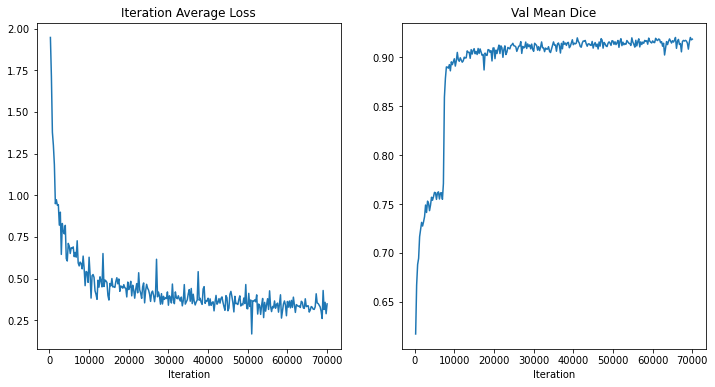

In [12]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

### Check best model output with the input image and label

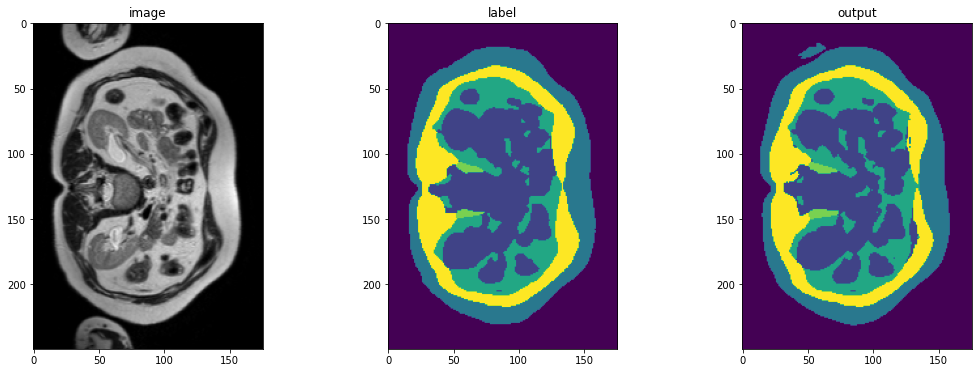

In [13]:
case_num = 0
model.load_state_dict(torch.load(os.path.join(data_dir, "TestMR05_multiclassUNetR_Sep23.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).to(device)
    val_labels = torch.unsqueeze(label, 1).to(device)
    val_outputs = sliding_window_inference(
        val_inputs, (96, 96, 16), 4, model, overlap=0.8
    )
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, 5], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, 5])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(
        torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 5]
    )
    plt.show()
    

In [ ]:
# val_inputs.shape

### Inference on test images

In [ ]:
# if directory is None:
#     shutil.rmtree(root_dir)

In [12]:
import glob
from monai.data import Dataset
from monai.handlers.utils import from_engine
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)

test_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTs/img_setof10", "A043_v3*.nii.gz")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 4.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=250,
            b_min=0.0, b_max=1.0, clip=False,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys="image"),
    ]
)

test_org_ds = Dataset(
    data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=test_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=6),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./outMR05_Sep23", output_postfix="seg", resample=False, separate_folder=False),
])

In [52]:
# print(data_dir)

2023-11-21 18:09:32,809 INFO image_writer.py:194 - writing: outMR05_Sep23/A043_v3_T2W_seg.nii.gz


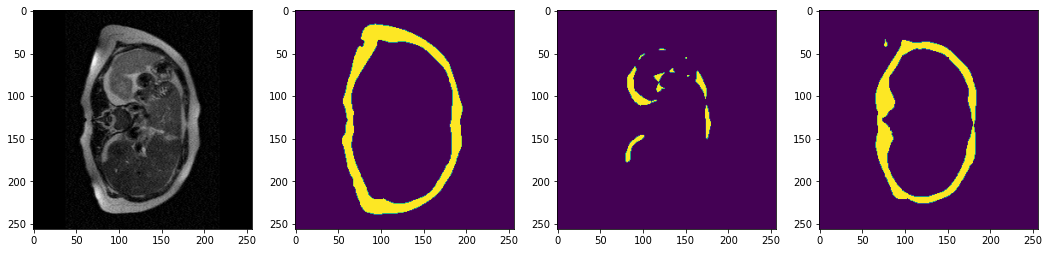

In [13]:
from monai.transforms import LoadImage
loader = LoadImage()

model.load_state_dict(torch.load(
    os.path.join(data_dir, "TestMR05_multiclassUNetR_Sep23.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (96, 96, 16)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model, overlap=0.8)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

#         # uncomment the following lines to visualize the predicted results
        test_output = from_engine(["pred"])(test_data)

        original_image = loader(test_data[0]["image_meta_dict"]["filename_or_obj"])[0]

        plt.figure("check", (18, 6))
        plt.subplot(1, 4, 1)
        plt.imshow(original_image[:, :, 8], cmap="gray")
        plt.subplot(1, 4, 2)
        plt.imshow(test_output[0].detach().cpu()[2, :, :, 8])
        plt.subplot(1, 4, 3)
        plt.imshow(test_output[0].detach().cpu()[3, :, :, 8])
        plt.subplot(1, 4, 4)
        plt.imshow(test_output[0].detach().cpu()[5, :, :, 8])
        plt.show()

In [ ]:
# # Testing code modified  (Based on validation block)

# from monai.transforms import LoadImage
# loader = LoadImage()

# model.load_state_dict(torch.load(
#     os.path.join(data_dir, "TestMR05_multiclassUNetR_Sep23.pth")))
# model.eval()

# with torch.no_grad():
#     for test_data in test_org_loader:
#         test_inputs = test_data["image"].to(device)
#         roi_size = (96, 96, 48)
#         sw_batch_size = 4
#         test_outputs = sliding_window_inference(
#             test_inputs, roi_size, sw_batch_size, model, overlap=0.8
#     )
# #     plt.figure("check", (18, 6))
# #     plt.subplot(1, 2, 1)
# #     plt.title("image")
# #     plt.imshow(test_inputs.cpu().numpy()[0, 0, :, :, 40], cmap="gray")
# #     plt.subplot(1, 2, 2)
# #     plt.title("output")
# #     plt.imshow(
# #         torch.argmax(test_outputs, dim=1).detach().cpu()[0, :, :, 40]
# #     )
# #     plt.show()      

In [14]:
!tar -cvzf outMR05_Sep23.tar.gz outMR05_Sep23

outMR05_Sep23/
outMR05_Sep23/A050_v4_T2W_seg.nii.gz
outMR05_Sep23/A065_v5_T2W_seg.nii.gz
outMR05_Sep23/A010_v5_T2W_seg.nii.gz
outMR05_Sep23/A035_v3_T2W_seg.nii.gz
outMR05_Sep23/A028_v1_T2W_seg.nii.gz
outMR05_Sep23/A051_v3_T2W_seg.nii.gz
outMR05_Sep23/A023_v4_T2W_seg.nii.gz
outMR05_Sep23/A043_v2_T2W_seg.nii.gz
outMR05_Sep23/A050_v1_T2W_seg.nii.gz
outMR05_Sep23/A035_v7_T2W_seg.nii.gz
outMR05_Sep23/A010_v2_T2W_seg.nii.gz
outMR05_Sep23/A050_v6_T2W_seg.nii.gz
outMR05_Sep23/A010_v4_T2W_seg.nii.gz
outMR05_Sep23/A028_v6_T2W_seg.nii.gz
outMR05_Sep23/A028_v5_T2W_seg.nii.gz
outMR05_Sep23/A043_v5_T2W_seg.nii.gz
outMR05_Sep23/A043_v4_T2W_seg.nii.gz
outMR05_Sep23/A065_v2_T2W_seg.nii.gz
outMR05_Sep23/A051_v2_T2W_seg.nii.gz
outMR05_Sep23/A051_v1_T2W_seg.nii.gz
outMR05_Sep23/A065_v3_T2W_seg.nii.gz
outMR05_Sep23/A043_v9_T2W_seg.nii.gz
outMR05_Sep23/A028_v3_T2W_seg.nii.gz
outMR05_Sep23/A028_v4_T2W_seg.nii.gz
outMR05_Sep23/A036_v1_T2W_seg.nii.gz
outMR05_Sep23/A010_v3_T2W_seg.nii.gz
outMR05_Sep23/A043_v3_T

In [ ]:
# !pwd

In [ ]:
# plt.figure("check", (18, 6))
# plt.subplot(1, 2, 1)
# plt.title("image")
# plt.imshow(test_inputs.cpu().numpy()[0, 0, :, :, 20], cmap="gray")
# plt.subplot(1, 2, 2)
# plt.title("output")
# plt.imshow(
#     torch.argmax(test_outputs, dim=1).detach().cpu()[0, :, :, 20]
# )
# plt.show()

In [ ]:
# print(test_output[0].shape)

In [ ]:
# slno = 20
# plt.figure("check1", (18, 6))
# plt.imshow(original_image[:, :, slno], cmap="gray")
# plt.figure("check2", (18, 6))
# plt.subplot(3, 3, 1)
# plt.imshow(test_output[0].detach().cpu()[0, :, :, slno])
# plt.subplot(3, 3, 2)
# plt.imshow(test_output[0].detach().cpu()[1, :, :, slno])
# plt.subplot(3, 3, 3)
# plt.imshow(test_output[0].detach().cpu()[2, :, :, slno])
# plt.subplot(3, 3, 4)
# plt.imshow(test_output[0].detach().cpu()[3, :, :, slno])
# plt.subplot(3, 3, 5)
# plt.imshow(test_output[0].detach().cpu()[4, :, :, slno])
# plt.subplot(3, 3, 6)
# plt.imshow(test_output[0].detach().cpu()[5, :, :, slno])
# plt.subplot(3, 3, 7)
# plt.imshow(test_output[0].detach().cpu()[6, :, :, slno])
# plt.subplot(3, 3, 8)
# plt.imshow(test_output[0].detach().cpu()[7, :, :, slno])
# plt.subplot(3, 3, 9)
# plt.imshow(test_output[0].detach().cpu()[8, :, :, slno])
# plt.show()